In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df = pd.read_csv("c:/Users/HP/Downloads/healthcare_dataset.csv")
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Risk
0,Tiffany Ramirez,81,Female,O-,Diabetes,17-11-2022,Patrick Parker,Wallace-Hamilton,Medicare,37490.98336,146,Elective,01-12-2022,Aspirin,Inconclusive,Need More Checks / CANNOT be Discharged
1,Ruben Burns,35,Male,O+,Asthma,01-06-2023,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.06485,404,Emergency,15-06-2023,Lipitor,Normal,"Can take discharge, But need to follow Prescri..."
2,Chad Byrd,61,Male,B-,Obesity,09-01-2019,Paul Baker,Walton LLC,Medicare,36874.89700,292,Emergency,08-02-2019,Lipitor,Normal,"Can take discharge, But need to follow Prescri..."
3,Antonio Frederick,49,Male,B-,Asthma,02-05-2020,Brian Chandler,Garcia Ltd,Medicare,23303.32209,480,Urgent,03-05-2020,Penicillin,Abnormal,Needs more attention and more tests
4,Mrs. Brandy Flowers,51,Male,O-,Arthritis,09-07-2021,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.34418,477,Urgent,02-08-2021,Paracetamol,Normal,"Can take discharge, But need to follow Prescri..."


In [73]:
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Name                10000 non-null  object        
 1   Age                 10000 non-null  int64         
 2   Gender              10000 non-null  object        
 3   Blood Type          10000 non-null  object        
 4   Medical Condition   10000 non-null  object        
 5   Date of Admission   10000 non-null  datetime64[ns]
 6   Doctor              10000 non-null  object        
 7   Hospital            10000 non-null  object        
 8   Insurance Provider  10000 non-null  object        
 9   Billing Amount      10000 non-null  float64       
 10  Room Number         10000 non-null  int64         
 11  Admission Type      10000 non-null  object        
 12  Discharge Date      3996 non-null   datetime64[ns]
 13  Medication          10000 non-null  object     

,Age,Date of Admission,Billing Amount,Room Number,Discharge Date
count,10000.000000,10000,10000.000000,10000.000000,3996
mean,51.452200,2021-05-01 21:53:25.439999744,25516.806778,300.082000,2021-05-12 05:03:47.027026688
min,18.000000,2018-10-30 00:00:00,1000.180837,101.000000,2018-01-11 00:00:00
25%,35.000000,2020-02-10 00:00:00,13506.523967,199.000000,2020-03-03 18:00:00
50%,52.000000,2021-05-02 00:00:00,25258.112565,299.000000,2021-05-06 12:00:00
75%,68.000000,2022-07-23 06:00:00,37733.913725,400.000000,2022-08-05 00:00:00
max,85.000000,2023-10-30 00:00:00,49995.902280,500.000000,2023-12-11 00:00:00
std,19.588974,NaN,14067.292709,115.806027,NaN


In [74]:
#Convert and Standardize Date/Time Columns

date_cols = ['Date of Admission', 'Discharge Date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col],dayfirst=True, errors = 'coerce')


In [75]:
# Simplify the verbose 'Risk' column labels for easier analysis

risk_mapping = {
    'Can take discharge, But need to follow Prescribed medications timely': 'Low Risk (Discharge)',
    'Needs more attention and more tests': 'Medium Risk (Monitor)',
    'Need More Checks / CANNOT be Discharged': 'High Risk (No Discharge)'
}
df['Risk_Category'] = df['Risk'].map(risk_mapping)
df.drop('Risk', axis=1, inplace=True) # Drop the original column

# Standardize case and remove extra spaces in relevant categorical columns
categorical_cols_to_clean = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider',
                             'Admission Type', 'Medication', 'Test Results']
for col in categorical_cols_to_clean:
    # Remove leading/trailing spaces and convert to Title Case (e.g., 'male' -> 'Male')
    df[col] = df[col].astype(str).str.strip().str.title()

In [77]:
# Remove exact duplicate rows (where ALL column values are identical)

initial_rows = len(df)
df.drop_duplicates(inplace=True)
removed_duplicates = initial_rows - len(df)

In [78]:
# Flag "near-duplicates" (potential repeat admissions for the same patient)
df['Is_Repeat_Admission'] = df.duplicated(subset=['Name', 'Age', 'Medical Condition'], keep='first')

In [79]:
numeric_cols_for_outlier = ['Age', 'Billing Amount']

for col in numeric_cols_for_outlier:
    # Calculate the 5th and 95th percentiles (P5 and P95)
    lower_bound = df[col].quantile(0.05)
    upper_bound = df[col].quantile(0.95)
    
    # Winsorization: Cap values below P5 to P5, and values above P95 to P95.
    df[f'{col}_Winsorized'] = np.where(df[col] < lower_bound, lower_bound,
                                       np.where(df[col] > upper_bound, upper_bound, df[col]))
    
    # Replace original column with the winsorized one
    df.drop(columns=[col], inplace=True)
    df.rename(columns={f'{col}_Winsorized': col}, inplace=True)

# Convert Age back to a whole number after winsorization
df['Age'] = df['Age'].round().astype(int)

In [80]:
# Calculate the difference between discharge and admission dates
df['Length_of_Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

In [ ]:
# Date Parts for time series analysis
df['Admission_Year'] = df['Date of Admission'].dt.year
df['Admission_Month'] = df['Date of Admission'].dt.month_name()

In [ ]:

# Length of Stay is minimum 1 day to prevent division by zero in the next step.
df['Length_of_Stay_Cap'] = df['Length_of_Stay'].apply(lambda x: max(x, 1)) 
df['Bill_Per_Day'] = df['Billing Amount'] / df['Length_of_Stay_Cap']
df.drop('Length_of_Stay_Cap', axis=1, inplace=True) 

In [86]:
df.head()

,Name,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Room Number,Admission Type,...,Test Results,Risk_Category,Is_Repeat_Admission,Age,Billing Amount,Length_of_Stay,Length_ofStay_Cap,Admission_Year,Admission_Month,Bill_Per_Day
0,Tiffany Ramirez,Female,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,146,Elective,...,Inconclusive,High Risk (No Discharge),False,81,37490.98336,-309.0,1.0,2022,November,37490.983360
1,Ruben Burns,Male,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",Unitedhealthcare,404,Emergency,...,Normal,Low Risk (Discharge),False,35,47304.06485,NaN,NaN,2023,June,NaN
2,Chad Byrd,Male,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,292,Emergency,...,Normal,Low Risk (Discharge),False,61,36874.89700,205.0,205.0,2019,January,179.877546
3,Antonio Frederick,Male,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,480,Urgent,...,Abnormal,Medium Risk (Monitor),False,49,23303.32209,-58.0,1.0,2020,May,23303.322090
4,Mrs. Brandy Flowers,Male,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",Unitedhealthcare,477,Urgent,...,Normal,Low Risk (Discharge),False,51,18086.34418,-151.0,1.0,2021,July,18086.344180


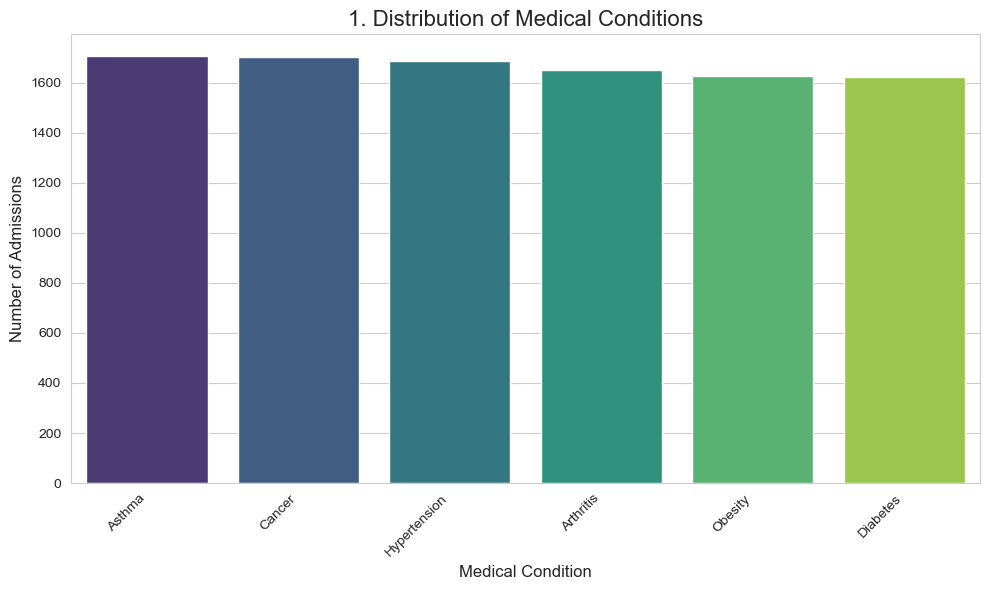

In [ ]:
#Distribution of Medical Conditions (Top-N Bar Chart)
plt.figure(figsize=(10, 6))

condition_counts = df['Medical Condition'].value_counts().sort_values(ascending=False)

sns.barplot(
    x=condition_counts.index,
    y=condition_counts.values,
    hue=condition_counts.index,
    palette="viridis",
    dodge=False,
    legend=False
)

plt.title("1. Distribution of Medical Conditions", fontsize=16)
plt.xlabel("Medical Condition", fontsize=12)
plt.ylabel("Number of Admissions", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("chart_1_medical_condition_distribution.png")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_24412\2111811366.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


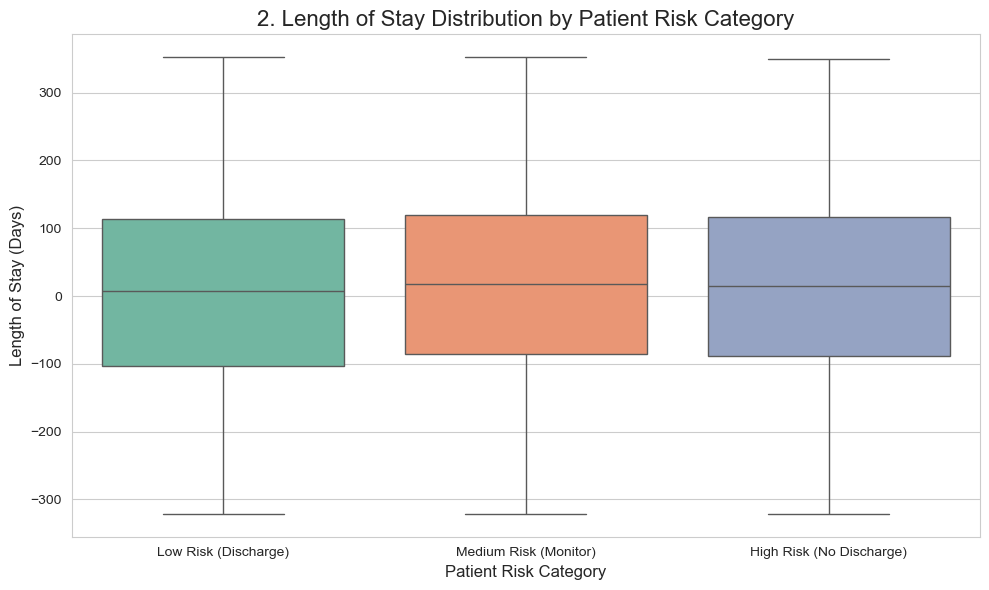

In [96]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Risk_Category',
    y='Length_of_Stay',
    data=df,
    order=['Low Risk (Discharge)', 'Medium Risk (Monitor)', 'High Risk (No Discharge)'],
    palette='Set2'
)

plt.title('2. Length of Stay Distribution by Patient Risk Category', fontsize=16)
plt.xlabel('Patient Risk Category', fontsize=12)
plt.ylabel('Length of Stay (Days)', fontsize=12)
plt.tight_layout()
plt.savefig('chart_2_los_by_risk.png')
plt.show()


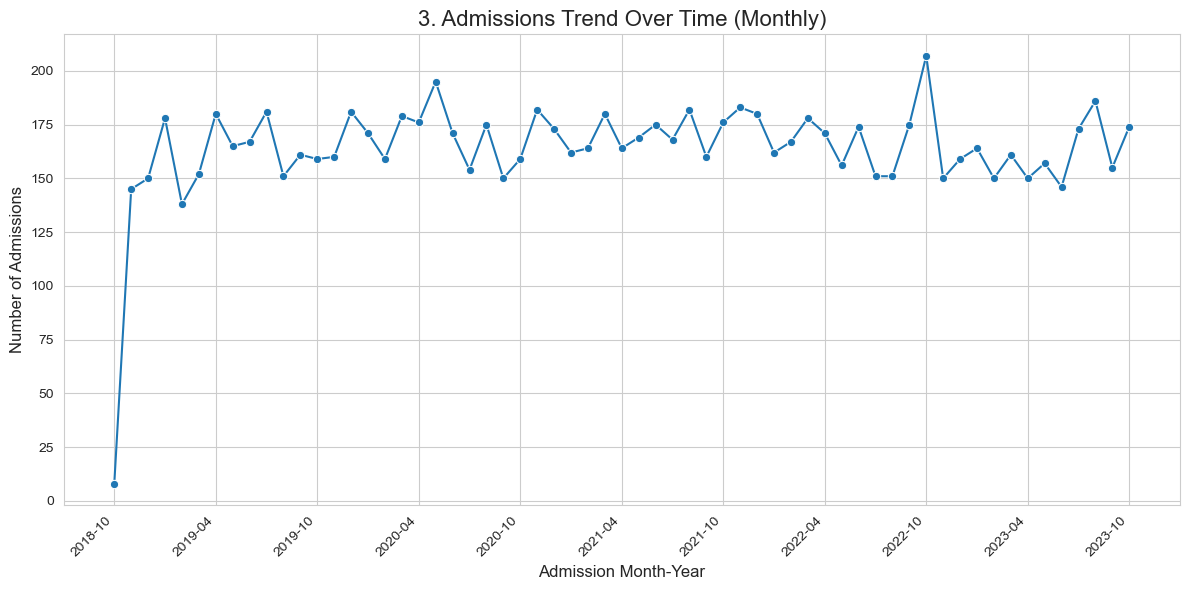

In [ ]:
# Admissions Trend Over Time (Time Series)

# Group by month-year
admissions_ts = df.groupby(df['Date of Admission'].dt.to_period('M'))['Name'].count().reset_index()
admissions_ts['Date of Admission'] = admissions_ts['Date of Admission'].astype(str)

plt.figure(figsize=(12, 6))

ax = sns.lineplot(
    x='Date of Admission',
    y='Name',
    data=admissions_ts,
    marker='o'   
)

plt.title('3. Admissions Trend Over Time (Monthly)', fontsize=16)
plt.xlabel('Admission Month-Year', fontsize=12)
plt.ylabel('Number of Admissions', fontsize=12)

# Show x-tick every 6 months
tick_indices = np.arange(0, len(admissions_ts), 6)
plt.xticks(admissions_ts['Date of Admission'].iloc[tick_indices], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('chart_3_admissions_trend.png')
plt.show()


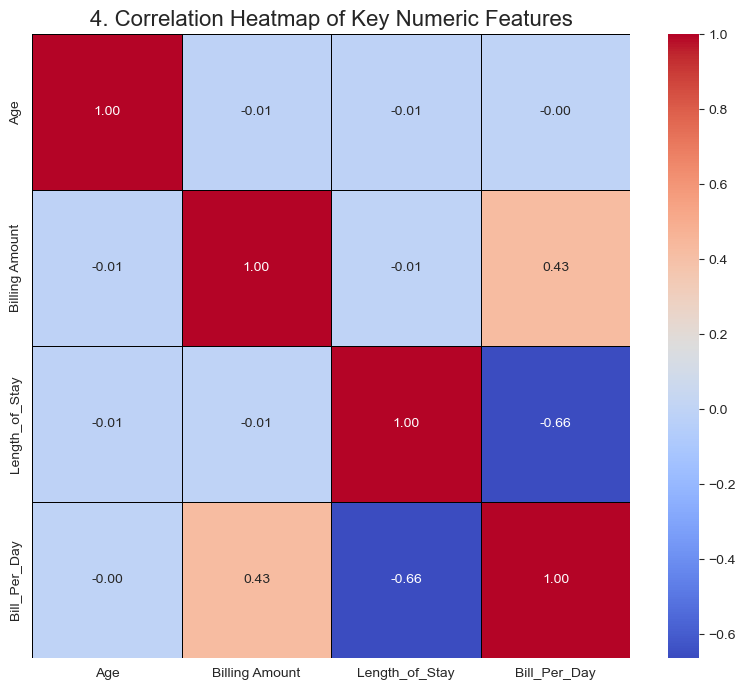

In [ ]:
# Correlation Heatmap of Numeric Features

numeric_features = df[['Age', 'Billing Amount', 'Length_of_Stay', 'Bill_Per_Day']]
corr_matrix = numeric_features.corr()

plt.figure(figsize=(8, 7))

sns.heatmap(
    corr_matrix,
    annot=True,         
    fmt=".2f",          
    cmap='coolwarm',    
    cbar=True,          
    linewidths=0.5,     
    linecolor='black'   
)

plt.title('4. Correlation Heatmap of Key Numeric Features', fontsize=16)
plt.tight_layout()
plt.savefig('chart_4_correlation_heatmap.png')
plt.show()


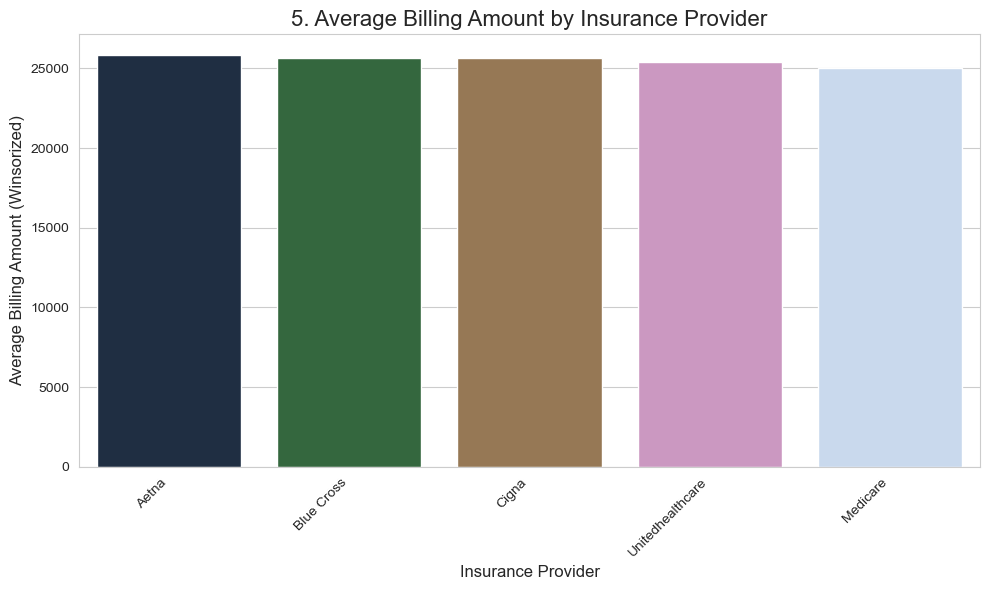

In [ ]:
plt.figure(figsize=(10, 6))

# Mean billing amount by insurance provider
billing_by_insurance = (
    df.groupby('Insurance Provider')['Billing Amount']
    .mean()
    .sort_values(ascending=False)
)

ax = sns.barplot(
    x=billing_by_insurance.index,
    y=billing_by_insurance.values,
    hue=billing_by_insurance.index,   
    palette='cubehelix',
    dodge=False,
    legend=False
)

plt.title('5. Average Billing Amount by Insurance Provider', fontsize=16)
plt.xlabel('Insurance Provider', fontsize=12)
plt.ylabel('Average Billing Amount (Winsorized)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('chart_5_billing_by_insurance.png')
plt.show()